In [1]:
%matplotlib widget
import os
import sys
import math

# Путь к директории, где находится текущий ноутбук
NOTEBOOK_DIR = os.path.abspath(os.path.dirname("__file__"))  # работает в Jupyter

# Поднимаемся на один уровень вверх – получаем корень проекта
PROJECT_ROOT = os.path.abspath(os.path.join(NOTEBOOK_DIR, os.pardir, 'src'))

# Добавляем корень в начало sys.path, если его там ещё нет
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

In [2]:
from pathlib import Path

from afr3d.io.step_import import extract_solids, load_step

step_path = Path("../data/example_complex.stp")
shape_raw = load_step(step_path)
shape = extract_solids(shape_raw)

In [3]:
from afr3d.views.visibility import compute_face_visibility_by_zbuffer
from OCC.Core.gp import gp_Pnt, gp_Dir, gp_Ax2

origin = gp_Pnt(0, 0, 0)
ax2_front = gp_Ax2(origin, gp_Dir(0, 0, -1), gp_Dir(0, 1, 0))

front_face_vis = compute_face_visibility_by_zbuffer(shape, ax2_front)
print("видимых граней на front:", len(front_face_vis.visible_faces))

видимых граней на front: 153


In [4]:
from afr3d.views.analytic import build_analytic_view_2d

front_view = build_analytic_view_2d(
    shape,
    view_ax2=ax2_front,
    view_name="front",
    face_visibility=front_face_vis,
    n_edge_samples=32,
)

print("всего вершин:", len(front_view.vertices))
print("всего рёбер:", len(front_view.edges))

всего вершин: 244
всего рёбер: 393


In [5]:
from OCC.Core.gp import gp_Ax2, gp_Pnt, gp_Dir
from OCC.Core.HLRBRep import HLRBRep_Algo, HLRBRep_HLRToShape
from OCC.Core.HLRAlgo import HLRAlgo_Projector
from OCC.Core.TopoDS import TopoDS_Shape

def build_hlr_projection_ax2(
    shape: TopoDS_Shape,
    view_ax2: gp_Ax2,
):
    """
    Строит HLR-проекцию для заданного вида (gp_Ax2).

    Возвращает:
        projection: dict со shape'ами:
            {
              "visible":         TopoDS_Shape,
              "hidden":          TopoDS_Shape,
              "outline_visible": TopoDS_Shape или None,
              "outline_hidden":  TopoDS_Shape или None,
            }
        view_ax2: тот же gp_Ax2 (для согласованности интерфейса)
    """
    algo = HLRBRep_Algo()
    algo.Add(shape)

    projector = HLRAlgo_Projector(view_ax2)
    algo.Projector(projector)
    algo.Update()
    algo.Hide()  # запуск вычисления видимости

    hlr_to_shape = HLRBRep_HLRToShape(algo)

    visible = hlr_to_shape.VCompound()
    hidden = hlr_to_shape.HCompound()

    try:
        outline_visible = hlr_to_shape.Rg1LineVCompound()
    except Exception:
        outline_visible = None

    try:
        outline_hidden = hlr_to_shape.Rg1LineHCompound()
    except Exception:
        outline_hidden = None

    projection = {
        "visible": visible,
        "hidden": hidden,
        "outline_visible": outline_visible,
        "outline_hidden": outline_hidden,
    }
    return projection, view_ax2

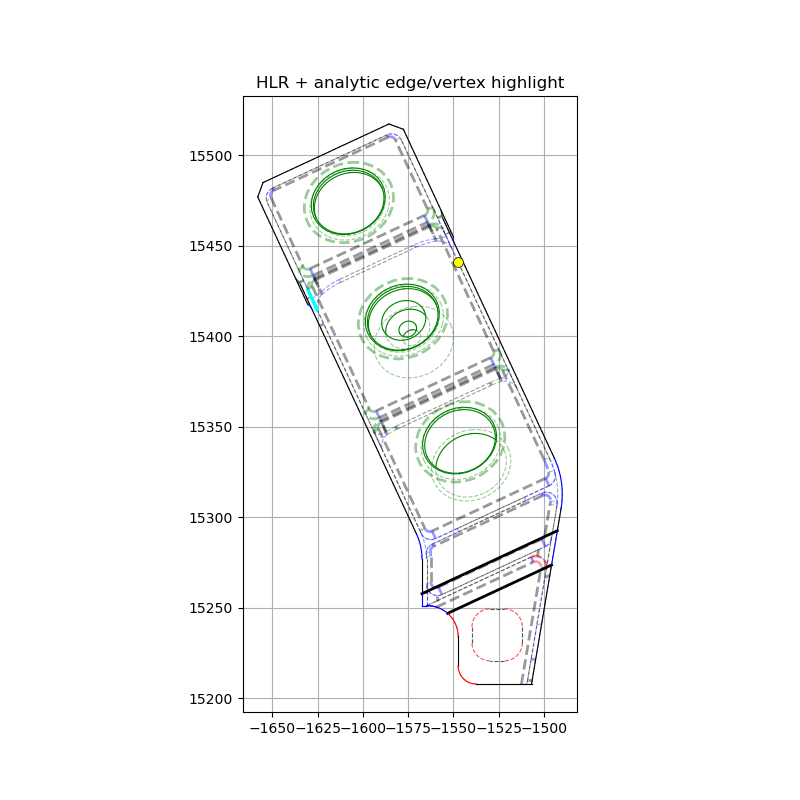

In [6]:
import matplotlib.pyplot as plt
from afr3d.views.plotting import build_hlr_projection_ax2, draw_hlr_compound_by_type, highlight_edge_on_view, highlight_vertex_on_view

# HLR-проекция — как раньше
projection, ax2_front = build_hlr_projection_ax2(shape, ax2_front)

visible         = projection["visible"]
hidden          = projection["hidden"]
outline_visible = projection["outline_visible"]
outline_hidden  = projection["outline_hidden"]

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal", "box")

draw_hlr_compound_by_type(ax, outline_hidden,  visible=False, is_outline=True)
draw_hlr_compound_by_type(ax, hidden,          visible=False, is_outline=False)
draw_hlr_compound_by_type(ax, outline_visible, visible=True,  is_outline=True)
draw_hlr_compound_by_type(ax, visible,         visible=True,  is_outline=False)

# подсветим ребро и вершину по индексам из аналитического вида
e_idx = 10
v_idx = 5

highlight_edge_on_view(ax, front_view.edges, e_idx, color="cyan", linewidth=2.5)
highlight_vertex_on_view(ax, front_view.vertices, v_idx, color="yellow", size=50.0)

ax.grid(True)
ax.set_title("HLR + analytic edge/vertex highlight")
plt.show()


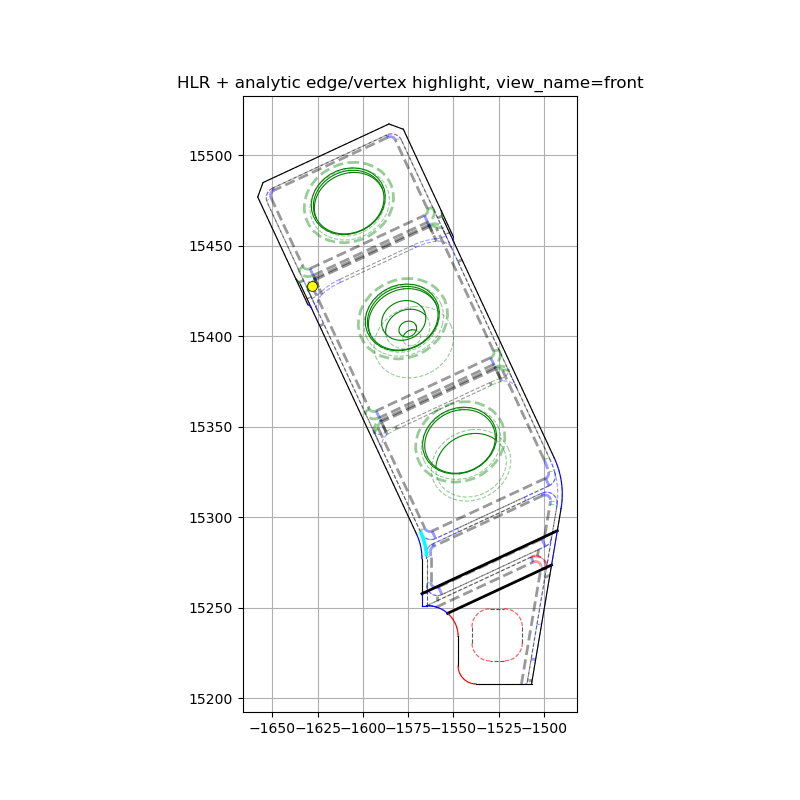

In [7]:
from afr3d.views.plotting import highlight_elements_on_view
highlight_elements_on_view(shape, ax2_front, 50, 25, 'front')

# Примеры использования связей vertex–edge–face

In [8]:
front_view = build_analytic_view_2d(
    shape,
    view_ax2=ax2_front,
    view_name="front",
    face_visibility=front_face_vis,
)
"""Он содержит: 
front_view.vertices: Dict[int, DraftVertex2D]
front_view.edges: Dict[int, DraftEdge2D]
front_view.face_map (индексация TopoDS_Face 1..N)
"""

'Он содержит: \nfront_view.vertices: Dict[int, DraftVertex2D]\nfront_view.edges: Dict[int, DraftEdge2D]\nfront_view.face_map (индексация TopoDS_Face 1..N)\n'

In [9]:
from afr3d.views.analytic import get_face_edges_and_vertices_on_view, describe_edge, describe_vertex, get_visible_elements

face_idx = 10
edges_on_face, vertices_on_face = get_face_edges_and_vertices_on_view(front_view, face_idx)

print(f"Грань #{face_idx}: рёбер={len(edges_on_face)}, вершин={len(vertices_on_face)}")

for e in edges_on_face[:5]:
    print(f"  edge {e.edge_index}, faces={e.face_indices}, curve_type={e.curve_type}, vis={e.visibility}")


Грань #10: рёбер=5, вершин=5
  edge 73, faces=[10, 77], curve_type=line, vis=visible
  edge 74, faces=[10, 89], curve_type=line, vis=visible
  edge 75, faces=[10, 47], curve_type=line, vis=visible
  edge 76, faces=[10, 94], curve_type=ellipse, vis=visible
  edge 77, faces=[10, 14], curve_type=line, vis=visible


In [10]:
describe_edge(front_view, 25)

Ребро #25:
  тип кривой: circle
  видимость:  visible
  граней:     [5, 128]
  вершины:    25 -> 26
  длина полилинии: 32 точек
    стартовая вершина: id=25, visible=True
    конечная вершина:  id=26, visible=True


In [11]:
describe_vertex(front_view, 7)

Вершина #7: (x=-1589.159, y=15337.089), visible=True
  инцидентные рёбра: [6, 9, 48, 324]
  прилегающие грани: [2, 7, 99, 113]


In [12]:
# Все видимые рёбра/вершины на виде
visible_dict = get_visible_elements(front_view)
for e in visible_dict['edges'][:5]:
    print(e)
for v in visible_dict['vertices'][:5]:
    print(v)

DraftEdge2D(edge_index=1, v_start=1, v_end=2, points=[(-1520.097532652369, 15382.338821781166), (-1524.434109221014, 15391.660388035714)], edge_3d=<class 'TopoDS_Edge'>, face_indices=[1, 108], curve_type='line', visibility='visible', line_style='solid', surface_types=['plane', 'cylinder'])
DraftEdge2D(edge_index=2, v_start=2, v_end=3, points=[(-1524.4341092210109, 15391.660388035702), (-1555.9751079606492, 15459.458455205082)], edge_3d=<class 'TopoDS_Edge'>, face_indices=[1, 125], curve_type='line', visibility='visible', line_style='solid', surface_types=['plane', 'cylinder'])
DraftEdge2D(edge_index=3, v_start=3, v_end=4, points=[(-1555.9751079606365, 15459.45845520509), (-1551.208431902944, 15449.21238068469)], edge_3d=<class 'TopoDS_Edge'>, face_indices=[1, 111], curve_type='line', visibility='visible', line_style='solid', surface_types=['plane', 'cylinder'])
DraftEdge2D(edge_index=4, v_start=4, v_end=5, points=[(-1551.2084319029357, 15449.212380684721), (-1551.1075726099282, 15448.9

# build_analytic_views_for_front_top_side

In [13]:
### из orientation.py
from dataclasses import dataclass
@dataclass
class OrientedAxes:
    origin: gp_Pnt
    d1: gp_Dir
    d2: gp_Dir
    d3: gp_Dir
    
from OCC.Core.Bnd import Bnd_OBB
from OCC.Core.BRepBndLib import brepbndlib
def compute_obb(shape):
    """
    Строит OBB для shape.
    Возвращает:
        center: gp_Pnt
        axes: (d1, d2, d3) как gp_Dir
        sizes: (sx, sy, sz) — полные размеры
    """
    obb = Bnd_OBB()
    brepbndlib.AddOBB(shape, obb, True, True, True)

    c = obb.Center()  # в некоторых версиях это не чистый gp_Pnt
    center = gp_Pnt(c.X(), c.Y(), c.Z())

    d1 = obb.XDirection()
    d2 = obb.YDirection()
    d3 = obb.ZDirection()

    sx = 2.0 * obb.XHSize()
    sy = 2.0 * obb.YHSize()
    sz = 2.0 * obb.ZHSize()

    return center, (d1, d2, d3), (sx, sy, sz)

def compute_obb_axes(shape) -> OrientedAxes:
    """
    Compute obb wrap
    """
    center, axes, sizes = compute_obb(shape)
    center_pnt = gp_Pnt(center.X(), center.Y(), center.Z())
    return OrientedAxes(
        origin=center_pnt,
        d1=axes[0],
        d2=axes[1],
        d3=axes[2]
    )

In [14]:
from afr3d.drafting.views import select_main_views

def make_default_front_top_side_ax2(shape: TopoDS_Shape) -> Dict[str, gp_Ax2]:
    """
    Простейший выбор front/top/side из осей OBB.
    Нормали:
      front ~ -d3,
      top   ~ -d2,
      side  ~ +d1.
    """
    main_views = select_main_views(shape)

    return {
        "front": main_views.front.ax2,
        "top":   main_views.top.ax2,
        "side":  main_views.side.ax2,
    }

NameError: name 'Dict' is not defined

In [ ]:
from typing import Literal, Dict
from afr3d.views.visibility import compute_face_visibility_by_zbuffer
from afr3d.views.analytic import build_analytic_view_2d, AnalyticView2D


def build_analytic_views_for_front_top_side(
    shape: TopoDS_Shape,
    edge_samples: int = 32,
) -> Dict[str, AnalyticView2D]:
    """
    1) Строит Ax2 для front/top/side на основе OBB-осей.
    2) Для каждого вида считает z-buffer видимости граней.
    3) На основе видимости граней строит AnalyticView2D (вершины/рёбра/грани)
       с заполненными типами поверхностей и типами линий.
    """
    view_axes_map = make_default_front_top_side_ax2(shape)
    analytic_views: Dict[str, AnalyticView2D] = {}

    for name, ax2 in view_axes_map.items():
        face_vis = compute_face_visibility_by_zbuffer(
            shape,
            ax2,
            grid_size=256,
            deflection=5e-4,
            angle=0.5,
        )

        view = build_analytic_view_2d(
            shape,
            view_ax2=ax2,
            view_name=name,
            face_visibility=face_vis,
            n_edge_samples=edge_samples,
        )
        analytic_views[name] = view

    return analytic_views

In [ ]:
axes = compute_obb_axes(shape)

In [ ]:
VisibilityFilter = Literal[
    "all",
    "visible_only",
    "hidden_only",
    "visible_plus_silhouette",
]


def filter_edges_by_visibility(view: AnalyticView2D, mode: VisibilityFilter):
    """
    Возвращает список рёбер для рисования в зависимости от фильтра видимости.
    """
    if mode == "all":
        return list(view.edges.values())
    elif mode == "visible_only":
        return [e for e in view.edges.values() if e.visibility == "visible"]
    elif mode == "hidden_only":
        return [e for e in view.edges.values() if e.visibility == "hidden"]
    elif mode == "visible_plus_silhouette":
        return [e for e in view.edges.values() if e.visibility in ("visible", "silhouette")]
    else:
        raise ValueError(f"Unknown visibility mode: {mode}")

In [ ]:
views = build_analytic_views_for_front_top_side(shape)

front_view = views["front"]
top_view   = views["top"]
side_view  = views["side"]

print("front:", len(front_view.edges), "edges")
print("top:",   len(top_view.edges),   "edges")
print("side:",  len(side_view.edges),  "edges")

# пример фильтра: только видимые+силуэтные рёбра фронтального вида
front_edges_for_draw = filter_edges_by_visibility(front_view, "visible_plus_silhouette")

front: 393 edges
top: 393 edges
side: 393 edges


# или строим в пару функций

In [15]:
from afr3d.views.analytic import build_analytic_views_for_front_top_side, filter_edges_by_visibility

views = build_analytic_views_for_front_top_side(shape)

front_view = views["front"]
top_view   = views["top"]
side_view  = views["side"]

print("front:", len(front_view.edges), "edges")
print("top:",   len(top_view.edges),   "edges")
print("side:",  len(side_view.edges),  "edges")

# пример фильтра: только видимые+силуэтные рёбра фронтального вида
front_edges_for_draw = filter_edges_by_visibility(front_view, "visible_plus_silhouette")

front: 393 edges
top: 393 edges
side: 393 edges


In [18]:
import matplotlib.pyplot as plt
from afr3d.views.analytic import DraftEdge2D, DraftVertex2D, AnalyticView2D

def draw_analytic_view_edges(
    view: AnalyticView2D,
    *,
    show_visible: bool = True,
    show_silhouette: bool = True,
    show_hidden: bool = True,
    fig_ax=None,
    title: str | None = None,
):
    """
    Простейший рендер аналитического вида через matplotlib.

    Использует:
      - edge.visibility  ('visible', 'silhouette', 'hidden', 'unknown')
      - edge.line_style  ('solid', 'hidden', 'solid_thick', ...)
    """
    if fig_ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    else:
        fig, ax = fig_ax

    ax.set_aspect("equal", "box")

    for e in view.edges.values():
        if not e.points or len(e.points) < 2:
            continue

        # фильтрация по видимости
        if e.visibility == "visible" and not show_visible:
            continue
        if e.visibility == "silhouette" and not show_silhouette:
            continue
        if e.visibility == "hidden" and not show_hidden:
            continue

        xs = [p[0] for p in e.points]
        ys = [p[1] for p in e.points]

        # выбираем стиль по line_style
        if e.line_style == "solid":
            ls = "-"
            lw = 1.0
            alpha = 1.0
        elif e.line_style == "solid_thick":
            ls = "-"
            lw = 1.8
            alpha = 1.0
        elif e.line_style == "hidden":
            ls = "--"
            lw = 0.8
            alpha = 0.6
        else:
            ls = "-"
            lw = 0.8
            alpha = 0.7

        ax.plot(xs, ys, linestyle=ls, linewidth=lw, alpha=alpha, color="black")

    ax.grid(True)
    if title is None:
        title = f"Analytic view: {view.view_name}"
    ax.set_title(title)

    return fig, ax

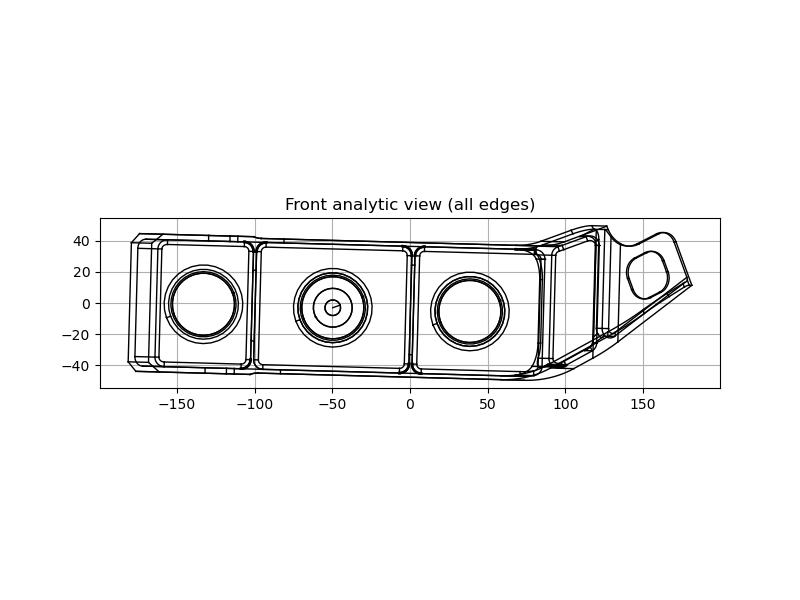

In [19]:
fig, ax = draw_analytic_view_edges(
    front_view,
    show_visible=True,
    show_silhouette=True,
    show_hidden=True,   # можно выключить, чтобы убрать штриховые
    title="Front analytic view (all edges)",
)
plt.show()

In [20]:
from OCC.Core.gp import gp_Ax2
from OCC.Core.HLRBRep import HLRBRep_Algo, HLRBRep_HLRToShape
from OCC.Core.HLRAlgo import HLRAlgo_Projector
from OCC.Core.TopoDS import TopoDS_Shape
from OCC.Core.BRepAdaptor import BRepAdaptor_Curve
from OCC.Core.GeomAbs import GeomAbs_Line
from OCC.Core.TopExp import TopExp_Explorer
from OCC.Core.TopAbs import TopAbs_EDGE

import matplotlib.pyplot as plt

# --- HLR: обёртка под Ax2 ---

def build_hlr_projection_ax2(shape: TopoDS_Shape, view_ax2: gp_Ax2):
    """
    Чистый HLR от OCCT для заданного gp_Ax2.
    Возвращает dict с shape'ами:
      visible, hidden, outline_visible, outline_hidden
    и тот же view_ax2.
    """
    algo = HLRBRep_Algo()
    algo.Add(shape)

    projector = HLRAlgo_Projector(view_ax2)
    algo.Projector(projector)
    algo.Update()
    algo.Hide()

    hlr_to_shape = HLRBRep_HLRToShape(algo)

    visible = hlr_to_shape.VCompound()
    hidden = hlr_to_shape.HCompound()

    try:
        outline_visible = hlr_to_shape.Rg1LineVCompound()
    except Exception:
        outline_visible = None

    try:
        outline_hidden = hlr_to_shape.Rg1LineHCompound()
    except Exception:
        outline_hidden = None

    return {
        "visible": visible,
        "hidden": hidden,
        "outline_visible": outline_visible,
        "outline_hidden": outline_hidden,
    }, view_ax2


# --- семплинг рёбер HLR-результата (важно: Х,У берём напрямую) ---

def sample_hlr_edge_2d(edge, n_samples: int = 32):
    """
    Семплируем ребро из HLR-shape.
    ВАЖНО: HLR уже выдал результат в плоскости вида, поэтому
           берём p.X(), p.Y() без дополнительной проекции через Ax2.
    """
    pts = []
    try:
        bac = BRepAdaptor_Curve(edge)
    except Exception:
        return pts

    try:
        first = bac.FirstParameter()
        last = bac.LastParameter()
    except Exception:
        return pts

    if last <= first:
        return pts

    if bac.GetType() == GeomAbs_Line:
        params = [first, last]
    else:
        params = [first + (last - first) * i / (n_samples - 1) for i in range(n_samples)]

    for u in params:
        try:
            p = bac.Value(u)
        except Exception:
            continue
        pts.append((p.X(), p.Y()))
    return pts


def draw_hlr_compound(ax, compound, *, color="black", linestyle="-", linewidth=1.0, alpha=1.0):
    """
    Рисуем один compound (visible / hidden / outline) HLR на axes.
    """
    if compound is None or compound.IsNull():
        return

    exp = TopExp_Explorer(compound, TopAbs_EDGE)
    while exp.More():
        edge = exp.Current()
        exp.Next()

        pts = sample_hlr_edge_2d(edge)
        if len(pts) < 2:
            continue

        xs = [p[0] for p in pts]
        ys = [p[1] for p in pts]
        ax.plot(xs, ys, color=color, linestyle=linestyle,
                linewidth=linewidth, alpha=alpha)

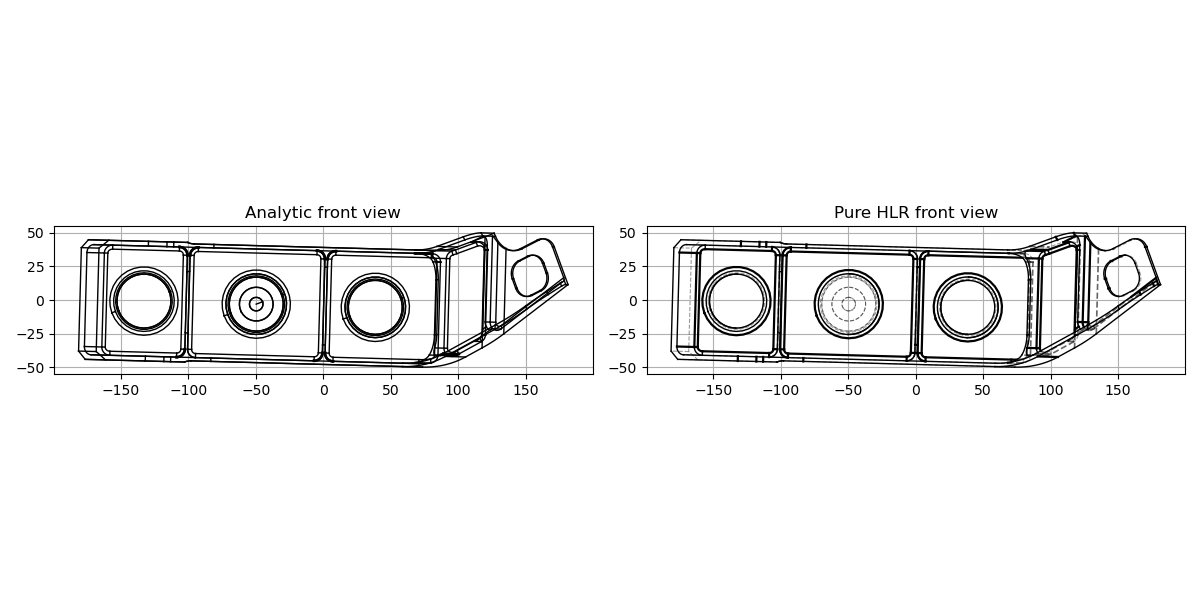

In [21]:
# предполагаем, что у тебя уже сделано:
# views = build_analytic_views_for_front_top_side(shape, edge_samples=32)
# front_view = views["front"]

# 1. Получаем чистый HLR для того же Ax2, что у аналитического вида
hlr_projection, ax2_hlr = build_hlr_projection_ax2(shape, front_view.ax2)

vis      = hlr_projection["visible"]
hid      = hlr_projection["hidden"]
out_vis  = hlr_projection["outline_visible"]
out_hid  = hlr_projection["outline_hidden"]

# 2. Два subplot'а: слева — analytic, справа — HLR
fig, (ax_ana, ax_hlr) = plt.subplots(1, 2, figsize=(12, 6))
ax_ana.set_aspect("equal", "box")
ax_hlr.set_aspect("equal", "box")

# слева — аналитический вид (только видимые + силуэтные, скрытые тоже можно включить)
draw_analytic_view_edges(
    front_view,
    show_visible=True,
    show_silhouette=True,
    show_hidden=True,        # можно False, если хочешь без штриховки
    fig_ax=(fig, ax_ana),
    title="Analytic front view",
)

# справа — натуральный HLR
# порядок: сначала скрытое, потом видимое, чтобы видимое легло сверху
draw_hlr_compound(ax_hlr, out_hid, color="black", linestyle="--", linewidth=1.2, alpha=0.6)
draw_hlr_compound(ax_hlr, hid,      color="black", linestyle="--", linewidth=0.8, alpha=0.4)
draw_hlr_compound(ax_hlr, out_vis,  color="black", linestyle="-",  linewidth=1.6, alpha=1.0)
draw_hlr_compound(ax_hlr, vis,      color="black", linestyle="-",  linewidth=1.0, alpha=1.0)

ax_hlr.grid(True)
ax_hlr.set_title("Pure HLR front view")

plt.tight_layout()
plt.show()

In [ ]:
from collections import Counter

def debug_edge_visibility_stats(view):
    vis_counter = Counter()
    style_counter = Counter()
    curve_counter = Counter()
    surf_counter = Counter()

    for e in view.edges.values():
        vis_counter[e.visibility] += 1
        style_counter[e.line_style] += 1
        curve_counter[e.curve_type] += 1
        if e.surface_types:
            for st in e.surface_types:
                surf_counter[st] += 1

    print(f"=== {view.view_name} / edges: {len(view.edges)} ===")
    print("visibility:", vis_counter)
    print("line_style:", style_counter)
    print("curve_type:", curve_counter)
    print("surface_types:", surf_counter)

    # вершины
    v_vis = sum(1 for v in view.vertices.values() if v.visible)
    print(f"vertices: {len(view.vertices)}, visible: {v_vis}")


In [ ]:
debug_edge_visibility_stats(front_view)

=== front / edges: 393 ===
visibility: Counter({'visible': 357, 'silhouette': 36})
line_style: Counter({'solid': 357, 'solid_thick': 36})
curve_type: Counter({'line': 179, 'circle': 118, 'ellipse': 51, 'bspline': 45})
surface_types: Counter({'plane': 344, 'cylinder': 297, 'bspline': 76, 'torus': 48, 'cone': 20})
vertices: 244, visible: 244


In [ ]:
from afr3d.views.analytic import count_faces_native
from afr3d.views.visibility import compute_face_visibility_by_zbuffer

ax2_front = front_view.ax2  # из твоего аналитического вида
face_vis_front = compute_face_visibility_by_zbuffer(shape, ax2_front)

print("faces total:", count_faces_native(shape))
print("faces visible by zbuffer:", len(face_vis_front.visible_faces))

faces total: 157
faces visible by zbuffer: 148


In [ ]:
# Резльтат - плохой. Проверка показывает, что у нас невидимых рёбер нет. Ошибка в логике.